In [1]:
%%html

<script
    src="https://code.jquery.com/jquery-3.7.1.slim.min.js"
    integrity="sha256-kmHvs0B+OpCW5GVHUNjv9rOmY0IvSIRcf7zGUDTDQM8="
    crossorigin="anonymous"></script>

<script
    src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.7/require.min.js"
    integrity="sha512-J5ha2LF4Le+PBQnI5+xAVJDR+sZG9uSgroy4n/A6TLjNkvYQbqZA8WHZdaOvJ0HiKkBC9Frmvs10rFDSHKmveQ=="
    crossorigin="anonymous"
    referrerpolicy="no-referrer"></script>


*TL;DR - This post replicates the neighbour-joining tree analysis from the recent paper by Kamau et al. (2024) on Anopheles coluzzii in northwestern Kenya.*

<hr/>

We recently worked with Luna Kamau's group at KEMRI to analyse genomic data from a survey of *Anopheles* mosquitoes across Kenya, which turned up the unexpected discovery of *Anopheles coluzzii* in northwestern Kenya. The analysis of the *An. coluzzii* data was published earlier this year in [Kamau et al. 2024](https://malariajournal.biomedcentral.com/articles/10.1186/s12936-024-04950-x), and Kelly Bennett from my team who worked on the analysis [presented the findings](https://youtu.be/kZ8U7QHoXY8?si=LP9CtfMJwdV3iyD9) at a recent MalariaGEN journal club.

In this post I thought I'd replicate one of the analyses and figures from the paper, which is a neighbour-joining tree investigating how the Kenyan *An. coluzzii* were genetically related to *An. coluzzii* from countries in West and Central Africa. It's also a good opportunity to demonstrate the [plot_njt()](https://malariagen.github.io/malariagen-data-python/latest/generated/malariagen_data.ag3.Ag3.plot_njt.html#malariagen_data.ag3.Ag3.plot_njt) function in the [malariagen_data](https://malariagen.github.io/malariagen-data-python/latest/index.html) Python API, which was recently added and used for this analysis. 

In [2]:
# Diagnostics.
import plotly
plotly.__version__

'5.24.0'

In [3]:
# Configure renderers for the blog post.
import plotly.io as pio
pio.renderers.default = "notebook_connected+plotly_mimetype"

## Setup

To begin with, set up access to data from the [Malaria Vector Genome Observatory](https://www.malariagen.net/vobs/).

In [4]:
import malariagen_data
ag3 = malariagen_data.Ag3(
    results_cache="results_cache",
)

The data are stored in Google Cloud Storage (GCS) in the us-central1 region. You can run this analysis on Google Colab, although you might need a bit of patience as Colab VMs can be in a different US region so may not be super close to the data, and also don't have a huge amount of compute power. I ran this analysis on a Vertex AI Workbench VM with 32 vCPU and 32 GB of RAM (e2-highcpu-32) and it took a couple of minutes. If you'd like to run this analysis yourself, see [Vector Observatory Data Access](https://malariagen.github.io/vector-data/vobs/vobs-data-access.html) for more info.

In [5]:
# hide progress for the blog post
ag3._show_progress = False

## Sample selection

The samples we're interested in are in sample set `1274-VO-KE-KAMAU-VMF00246` which comes from Luna Kamau's study [1274-VO-KE-KAMAU](https://www.malariagen.net/partner_study/1274-vo-ke-kamau/). This sample set is included in the [Ag3.9](https://malariagen.github.io/vector-data/ag3/ag3.9.html) release. I'm going to also include samples from the [*Anopheles gambiae* 1000 Genomes Project](https://www.malariagen.net/project/ag1000g/) (included in the [Ag3.0](https://malariagen.github.io/vector-data/ag3/ag3.0.html) release) and from [Fontaine et al. (2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4380269/) (included in [Ag3.10](https://malariagen.github.io/vector-data/ag3/ag3.10.html)) for comparison.

In [6]:
sample_sets = [
    # Samples from Kenya from Luna Kamau at KEMRI.
    "1274-VO-KE-KAMAU-VMF00246",
    # Ag1000G sample sets for comparison.
    "AG1000G-BF-A",
    "AG1000G-ML-A",
    "AG1000G-GH",
    "AG1000G-CI",
    "AG1000G-CF",
    "AG1000G-CM-B",
    "AG1000G-CM-C",
    "AG1000G-AO",
    # Samples from Fontaine et al. (2015).
    "fontaine-2015-rebuild",
]

For this analysis we are only interested in *Anopheles coluzzii*, so define a sample metadata query to select this taxon.

In [7]:
sample_query = "taxon == 'coluzzii'"

Take a look at how many samples will be included in the analysis.

In [8]:
df_count = ag3.count_samples(
    sample_sets=sample_sets,
    sample_query=sample_query,
    index=["sample_set", "country", "admin1_name"],
)
df_count

taxon                                                                    coluzzii
sample_set                country                  admin1_name                   
1274-VO-KE-KAMAU-VMF00246 Kenya                    Turkana                     26
AG1000G-AO                Angola                   Luanda                      81
AG1000G-BF-A              Burkina Faso             Hauts-Bassins               82
AG1000G-CF                Central African Republic Bangui                      18
AG1000G-CI                Cote d'Ivoire            Lagunes                     80
AG1000G-CM-B              Cameroon                 Far North                    2
                                                   North                        5
AG1000G-CM-C              Cameroon                 Adamaoua                     2
                                                   Centre                      12
                                                   Littoral                     2
                                                   North                        1
                                                   South                        2
AG1000G-GH                Ghana                    Central Region              25
                                                   Eastern Region               1
                                                   Greater Accra Region        14
                                                   Western Region              24
AG1000G-ML-A              Mali                     Koulikouro                  27
fontaine-2015-rebuild     Burkina Faso             Hauts-Bassins                3
                          Cameroon                 Centre                       4
                                                   South                        4

How many samples in total?

In [9]:
df_count["coluzzii"].sum()

np.int64(415)

## Neighbour-joining tree analysis

For this analysis, I'm going to use data from Chromosome 3 (`contig="3RL"`). I'll request 100,000 SNPs, requiring SNPs to have no missing genotype calls (`max_missing_an=0`) and a minimum minor allele count of 10 (`min_minor_ac=10`) because rare variants are less informative. All SNPs meeting these criteria will be found and then thinned to approximately the requested number.

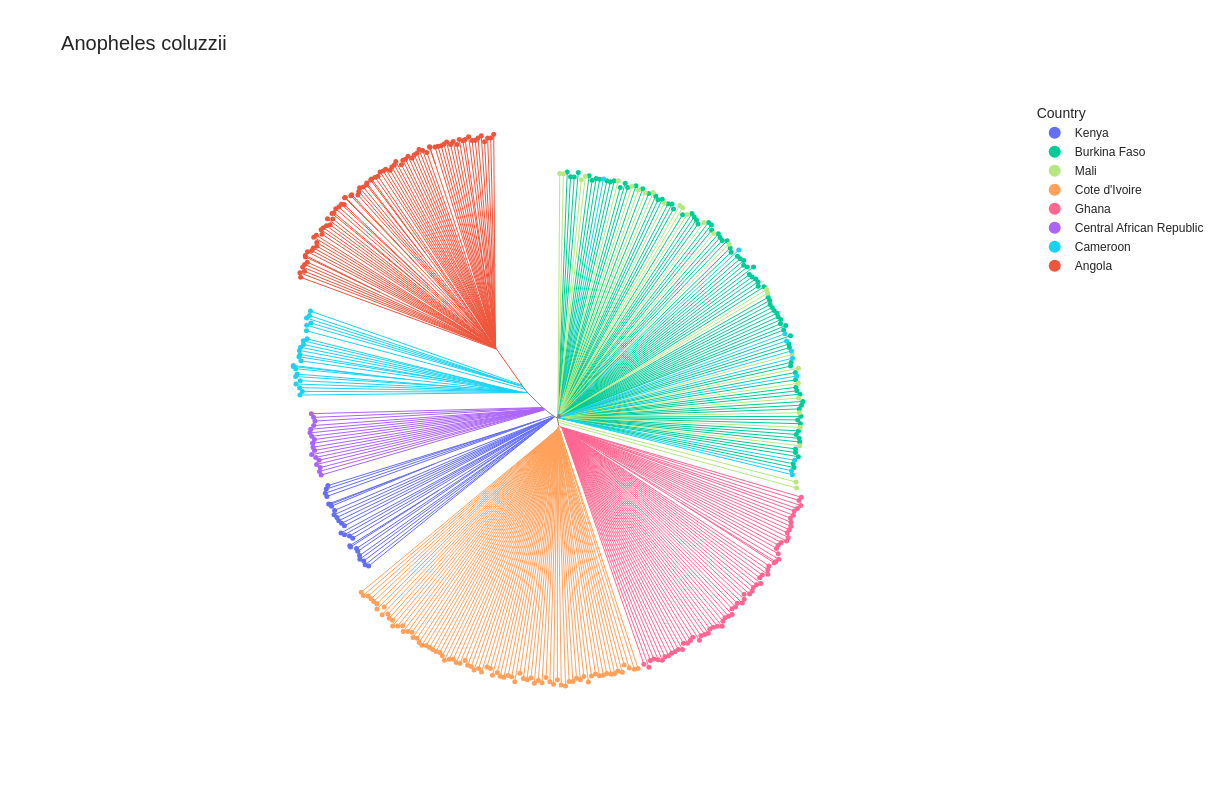

In [10]:
# Define the order that countries should appear in the legend.
category_orders = {
    "country": [
        "Kenya",
        "Burkina Faso",
        "Mali",
        "Cote d'Ivoire",
        "Ghana",
        "Central African Republic",
        "Cameroon", 
        "Angola",
    ],
}

# Compute and plot the neighbour-joining tree.
fig = ag3.plot_njt(
    metric="cityblock",
    title="Anopheles coluzzii",
    width=800,
    height=800,
    show=False,
    color="country",
    marker_size=5,
    line_width=1,
    category_orders=category_orders,
    region="3RL",
    n_snps=100_000,
    sample_sets=sample_sets,
    sample_query=sample_query,
    site_mask="gamb_colu",
    max_missing_an=0,
    min_minor_ac=10,
)

# Tidy up the plot.
fig.update_layout(
    legend=dict(
        title="Country",
    ),
    title_font=dict(
        size=20,
    ),
)

# Show the plot.
fig

This plot is interactive, you can hover over the leaf nodes (circle markers) which represent the individual mosquitoes and get more information about them such as location and date of sampling. The legend is also interactive, you can click on legend entries to show or hide different countries.

The Kenyan mosquitoes are plotted in blue, and are most closely connected to mosquitoes from Burkina Faso, Mali and northern Cameroon. 

## Topography and climate of northwestern Kenya

The Kenyan *An. coluzzii* came from Turkana which is in the northwestern part of the country, bordering South Sudan. More work is needed to understand how much connectivity and migration of *An. coluzzii* mosquitoes between Kenya and other countries, but I found it interesting to look at some maps of topography and climate and see how Turkana relates to surrounding areas.

Topographically, northwestern Kenya is more connected with South Sudan than with other regions of Kenya. Here's a [map of topography](https://en-gb.topographic-map.com/map-4d9jnh/The-World/?zoom=5&center=5.57225%2C17.95166):

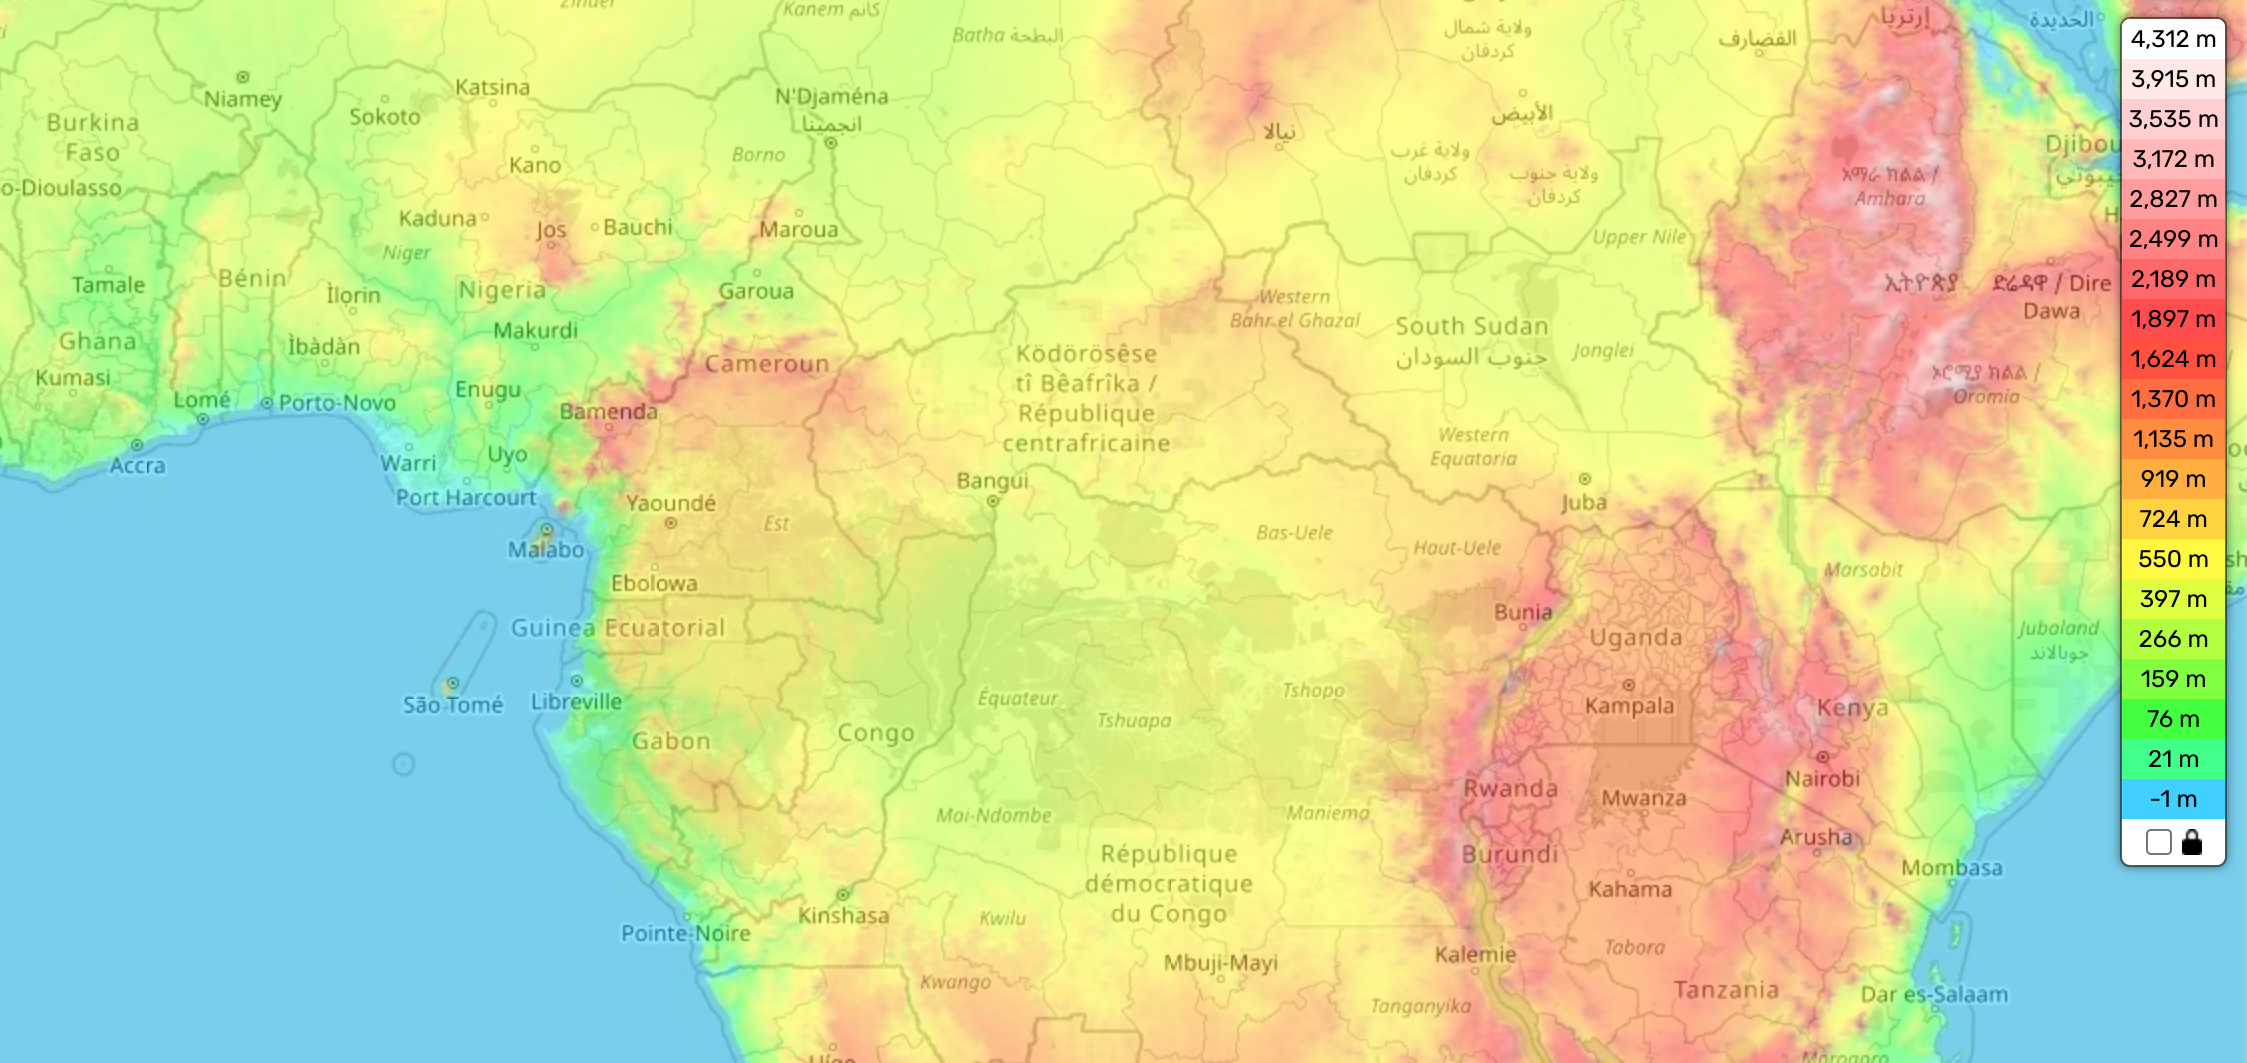

Climate is also interesting, because northwestern Kenya is very arid for at least part of the year, similar to Mali, Burkina Faso, northern Ghana and northern Cameroon. E.g., here's a [map of IPCC climate data](https://climatemaps.romgens.com/) from January which is the middle of the dry season north of the equator: 

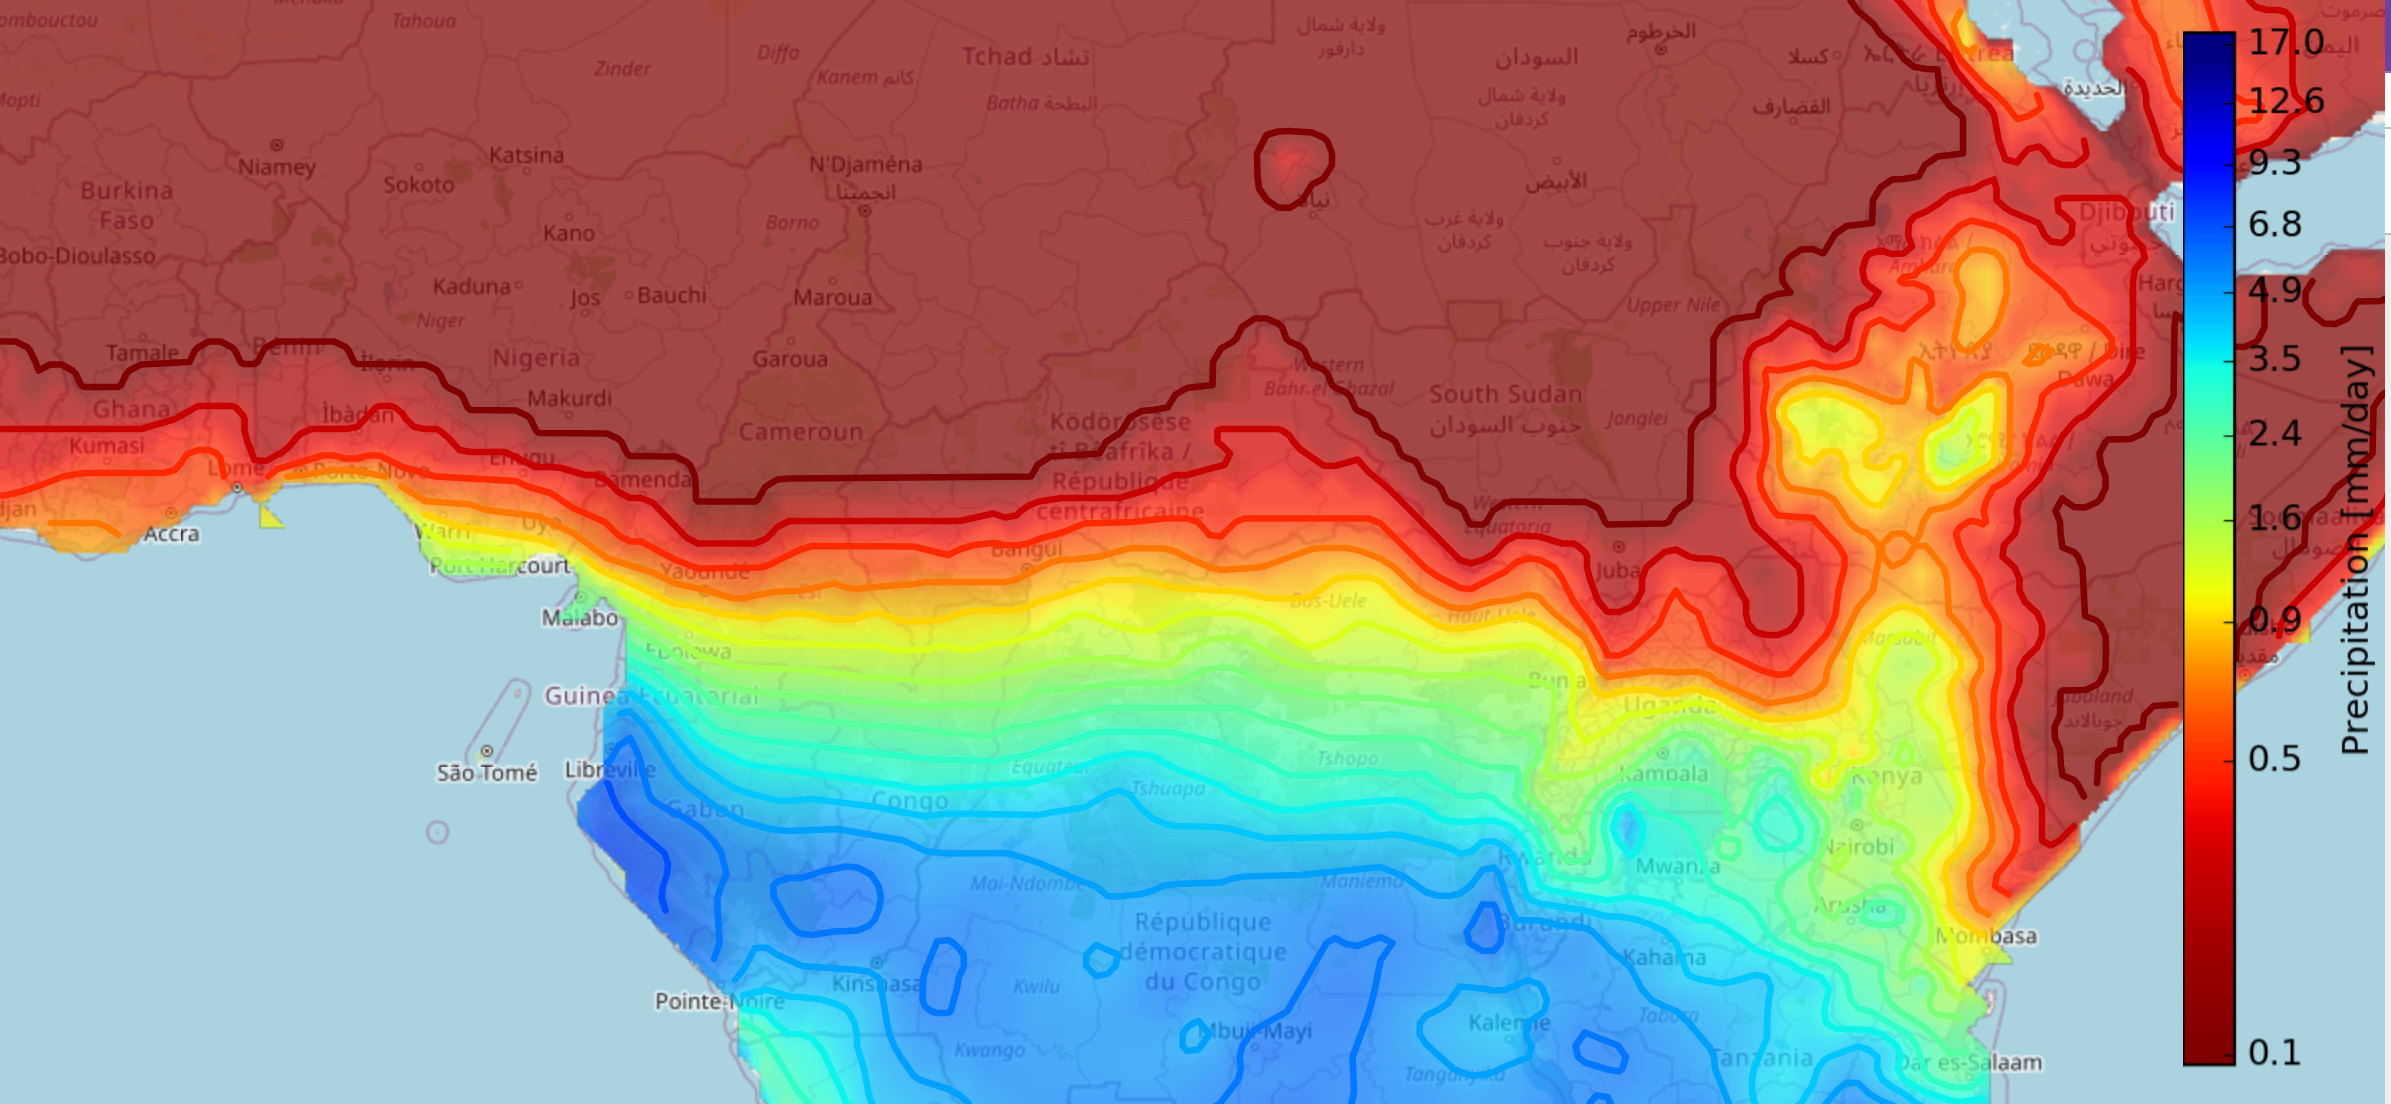

*An. coluzzii* is known for its ability to survive in regions with a longer dry season.

## Neighbour-joining tree implementation notes

The implementation of the `plot_njt()` function in the `malariagen_data` package uses [`biotite`](https://www.biotite-python.org/latest/apidoc/biotite.sequence.phylo.neighbor_joining.html#biotite.sequence.phylo.neighbor_joining) under the hood to compute the neighbour-joining tree from a distance matrix. There are also implementation of the neighbour-joining algorithm in BioPython and scikit-bio, but I did some benchmarking and `biotite` was the fastest.

To create an interactive plot of the resulting tree, I ended up implementing the equal angles layout, which is my favourite layout for unrooted trees, and plotting the results using Plotly. It would be amazing if there was a Python library that made interactive plots of different types of trees and layouts, like [ggtree](https://yulab-smu.top/treedata-book/chapter4.html#tree-layouts) but using Plotly or Bokeh, but I couldn't find anything yet. Interactivity is so useful for exploratory work, being able to hover over samples and zoom in and out really helps when you're trying to make sense of complicated datasets.

## Further reading

* [Kamau et al. (2024) The Anopheles coluzzii range extends into Kenya: detection, insecticide resistance profiles and population genetic structure in relation to conspecific populations in West and Central Africa](https://malariajournal.biomedcentral.com/articles/10.1186/s12936-024-04950-x).
* [plot_njt() API docs](https://malariagen.github.io/malariagen-data-python/latest/generated/malariagen_data.ag3.Ag3.plot_njt.html#malariagen_data.ag3.Ag3.plot_njt).